In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import scipy.signal as signal
import time
import cv2 as cv2
from joblib import Parallel, delayed

In [2]:
#Loading data functions
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    return imageio.imread(f'../../{group}-{student}.nosync.tif')

In [3]:
images = load_images(9,3)
images_mean = np.mean(images,axis=3)

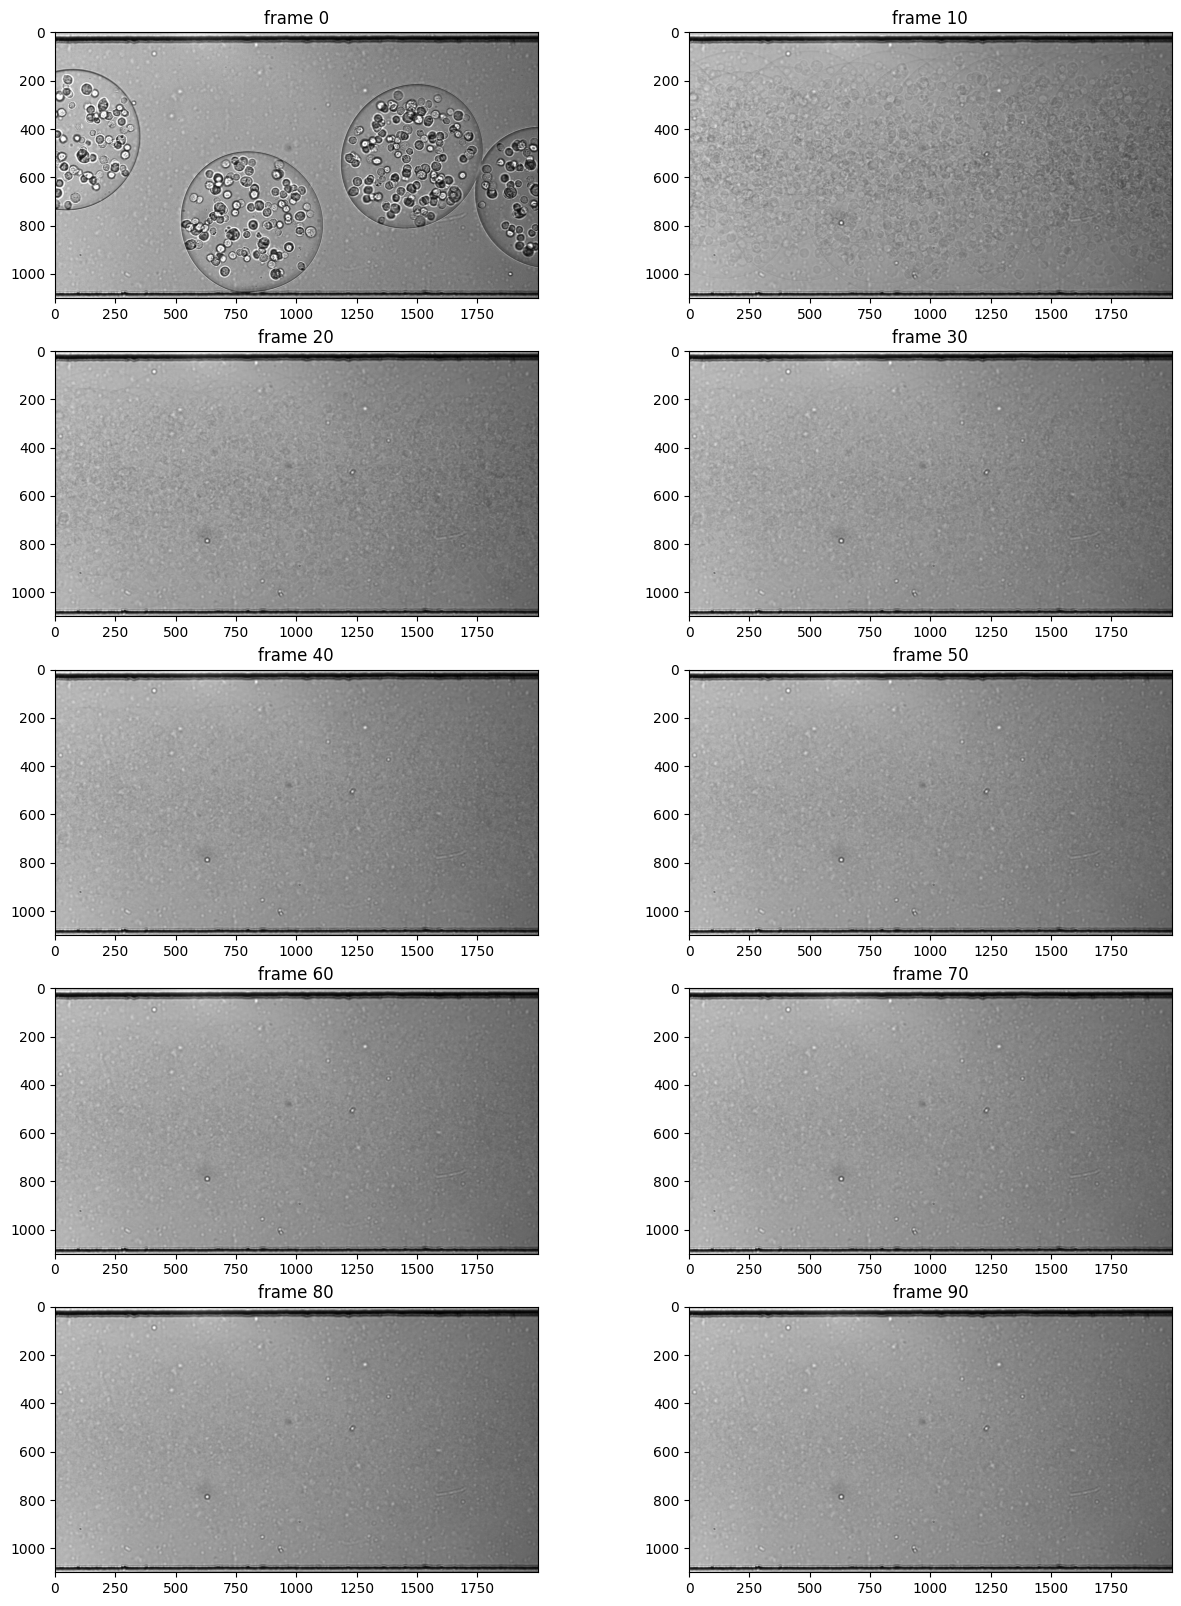

In [4]:
# Background frame by averaging i.e. naive method

background = np.zeros((10,images.shape[1],images.shape[2]))
background[0] = np.mean(images_mean[:1],axis=(0))

for i in range(1,10):
    background[i] = np.mean(images_mean[:10*i],axis=(0))

fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(background[i], cmap='gray')
    axs[i//2,i%2].set_title(f'frame {i*10}')
plt.show()

--- Execution time = 1.0029597282409668 seconds ---
--- Frame rate 0.010029597282409668 seconds/frame ---
--- Frame rate 99.7049005899611 frame/seconds ---


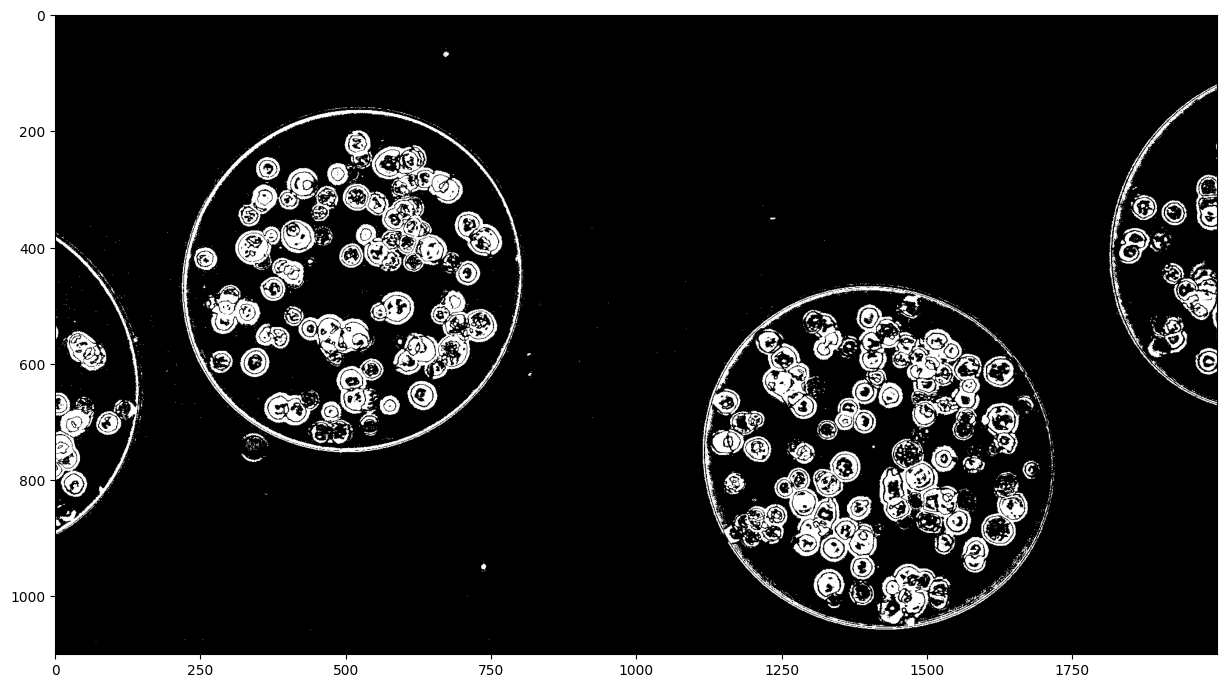

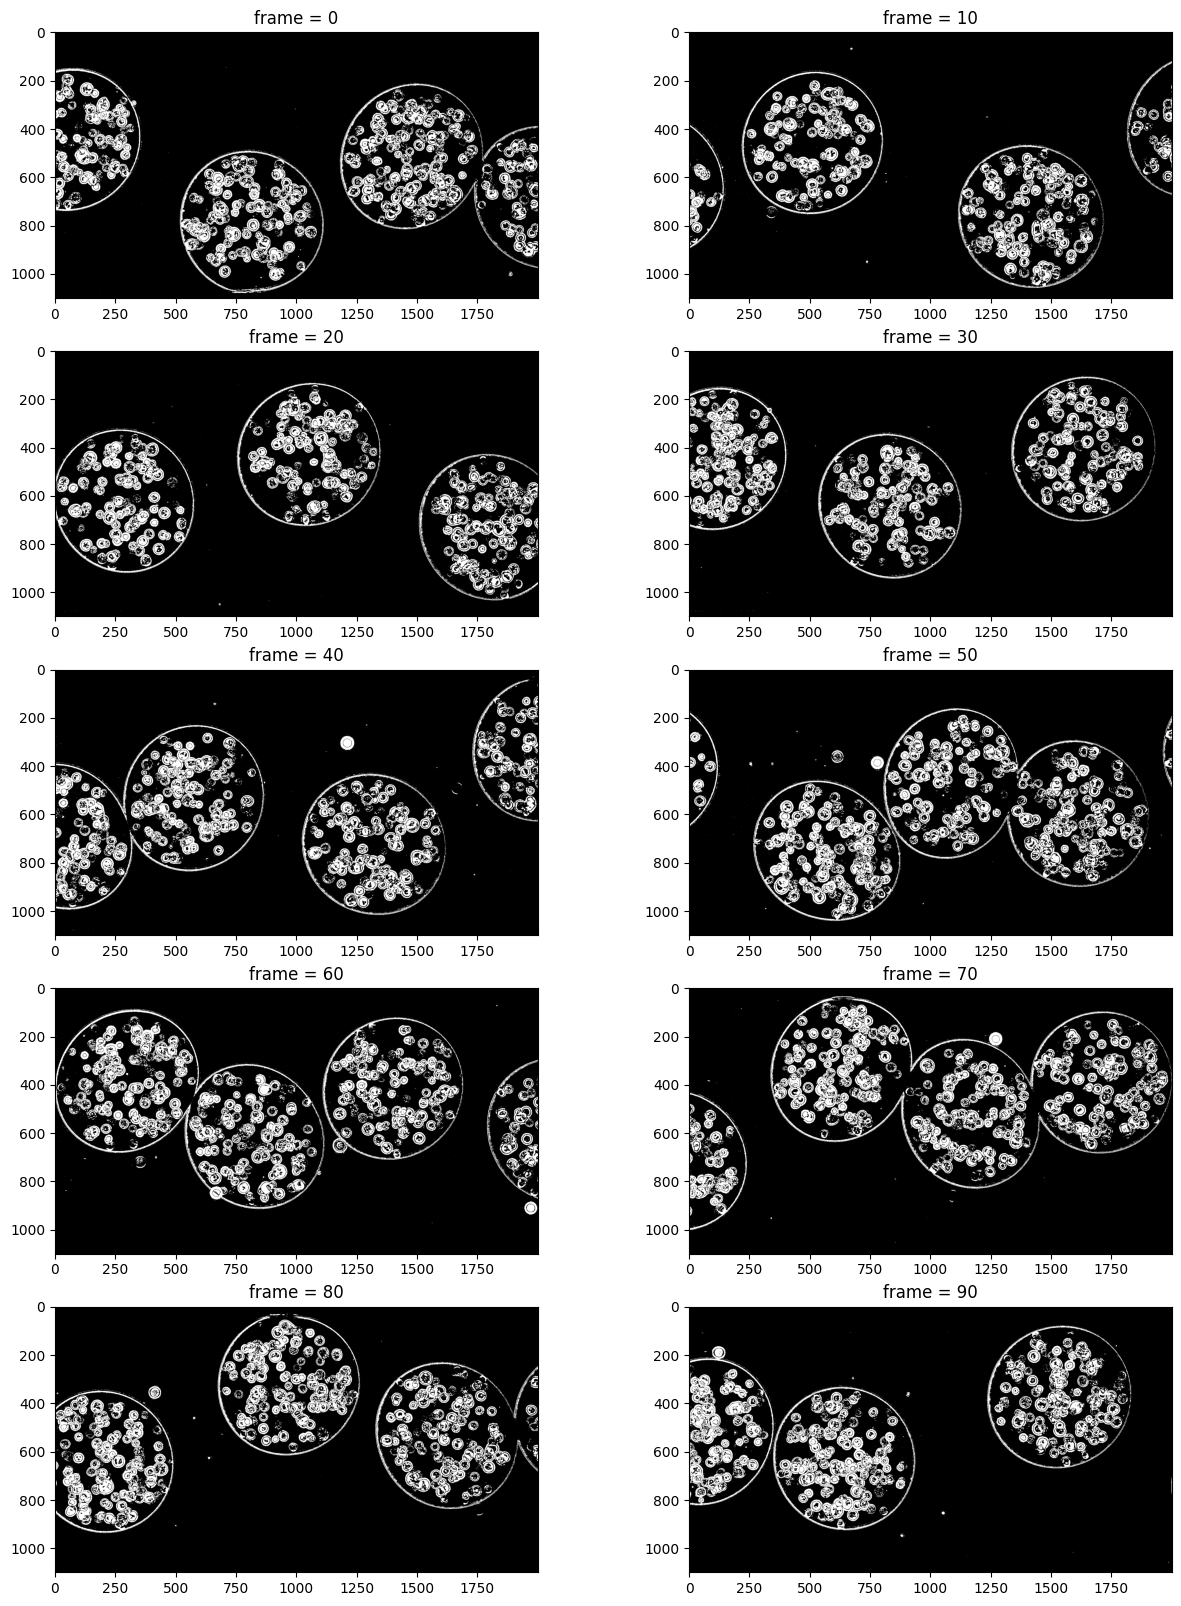

In [5]:
#Full Naive method LOOP parallelized and final result

show = True

nb_sample = 100
threshold = 0.15
back = background[9]
masks = np.zeros((nb_sample, images.shape[1],images.shape[2]))

def process(i,images_mean,back):
    im = images_mean[i]
    masks[i] =  (abs(im - back) / np.max(im)) > threshold
    return masks[i]

start_time = time.time()  
results = Parallel(n_jobs=-1, prefer="threads")(delayed(process)(i,images_mean,back) for i in range(nb_sample))
execution_time = time.time() - start_time

print("--- Execution time = %s seconds ---" % (execution_time))
print("--- Frame rate %s seconds/frame ---" % ((execution_time)/nb_sample))
print("--- Frame rate %s frame/seconds ---" % (nb_sample/(execution_time)))

_, image_thresh = cv2.threshold(masks[10], 100, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(15, 10))
plt.imshow(masks[10], cmap="gray")

if show:
    fig, axs = plt.subplots(5,2, figsize=(15,20))
    for i in range(10):
        axs[i//2,i%2].imshow(masks[i*10], cmap='gray')
        axs[i//2,i%2].set_title(f'frame = {10*i}')


Text(0.5, 1.0, 'frame = 90')

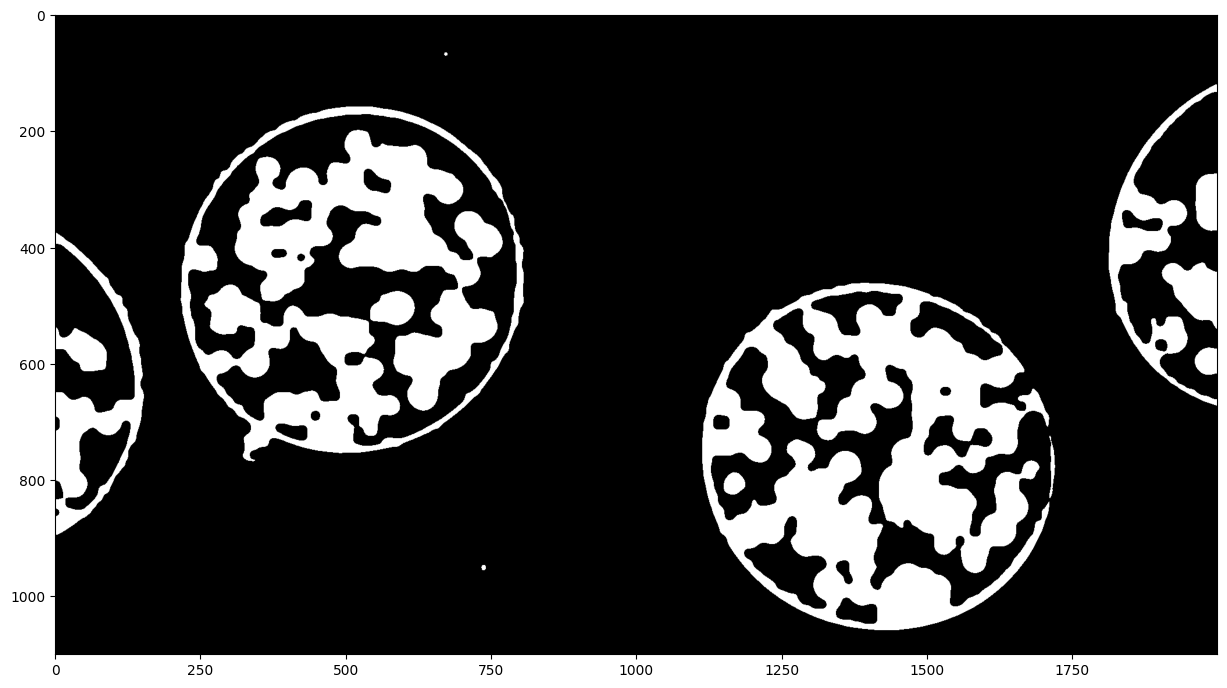

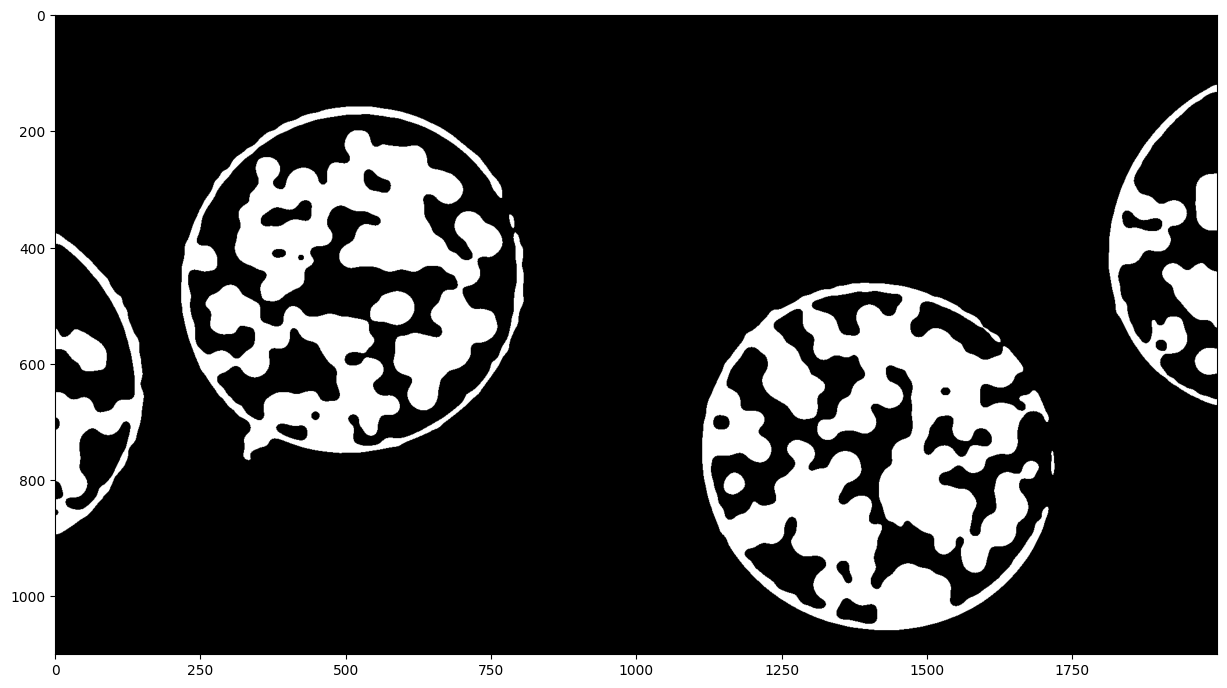

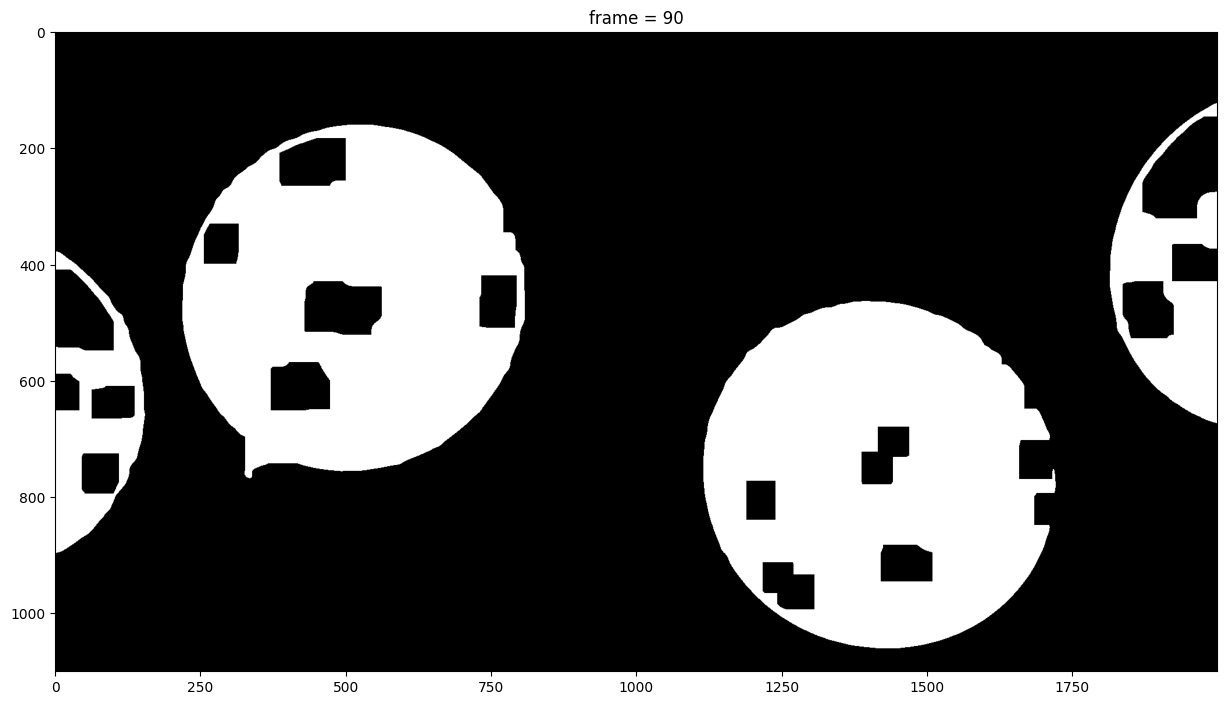

In [6]:
kernel = np.ones((15, 15), np.uint8)

closed = cv2.morphologyEx(masks[10], cv2.MORPH_CLOSE, kernel=kernel)


blur = cv2.GaussianBlur(closed, (25,25), 0)


th_blur = cv2.threshold(blur, 0.4, 1, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(15, 10))
plt.imshow(th_blur, cmap="gray")

blur = cv2.GaussianBlur(th_blur, (25,25), 0)


th_blur = cv2.threshold(blur, 0.5, 1, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(15, 10))
plt.imshow(th_blur, cmap="gray")

kernel = np.ones((50, 50), np.uint8)
dilated = cv2.morphologyEx(th_blur, cv2.MORPH_CLOSE, kernel=kernel)
kernel = np.ones((50, 50), np.uint8)
dilated = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel=kernel)

plt.figure(figsize=(15, 10))
plt.imshow(dilated, cmap="gray")
plt.title(f'frame = {10*i}')


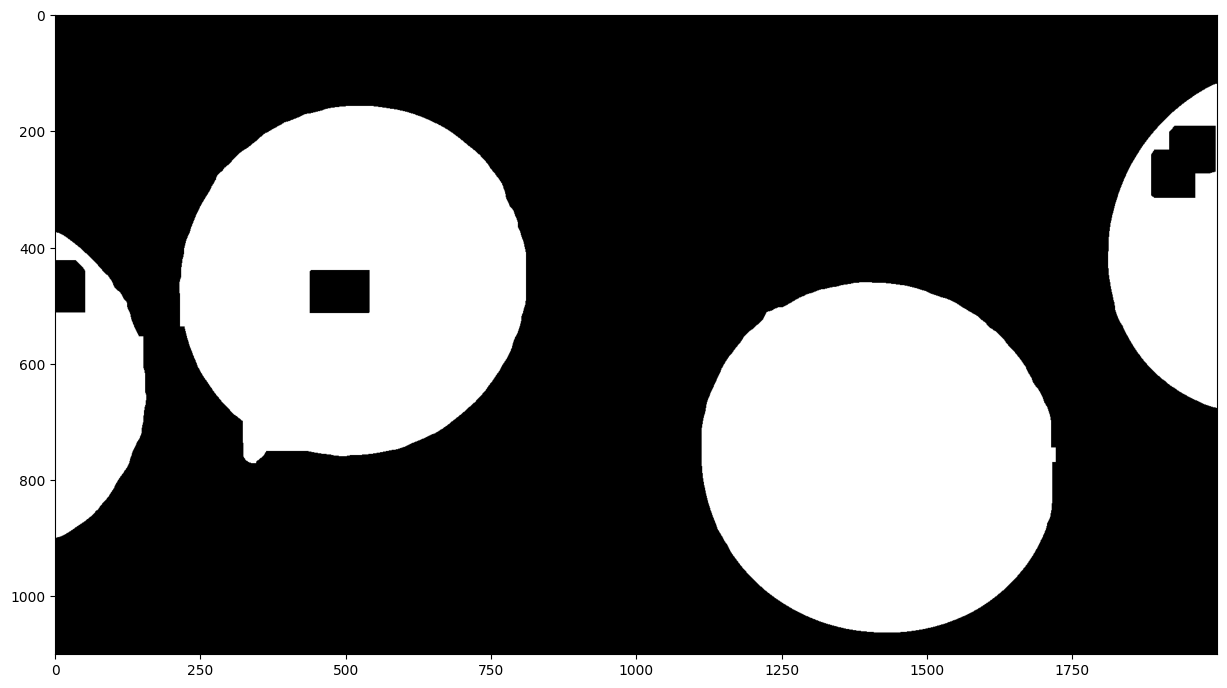

In [7]:
image = masks[10]
kernel1 = np.ones((15, 15), np.uint8)
kernel2 = np.ones((8, 8), np.uint8)
kernel3 = np.ones((30, 30), np.uint8)

image  = cv2.dilate(image, kernel=kernel2)

#median blur
# if image < 0.5: 0 else 255
image2 = np.where(image < 0.5, 0, 255)
image2 = image2.astype(np.uint8)


image = cv2.medianBlur(image2, 27)

image = image/255
#plt.figure(figsize=(15, 10))
#plt.imshow(image, cmap="gray")

image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel=kernel3, iterations=1)

#image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel=kernel2)

image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel=kernel1, iterations=5)

#image = cv2.blur(image, (20,20))

#image = cv2.threshold(image, 0.7, 1, cv2.THRESH_BINARY)[1]

#image = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel=kernel2, iterations=1)

plt.figure(figsize=(15, 10))
plt.imshow(image, cmap="gray")

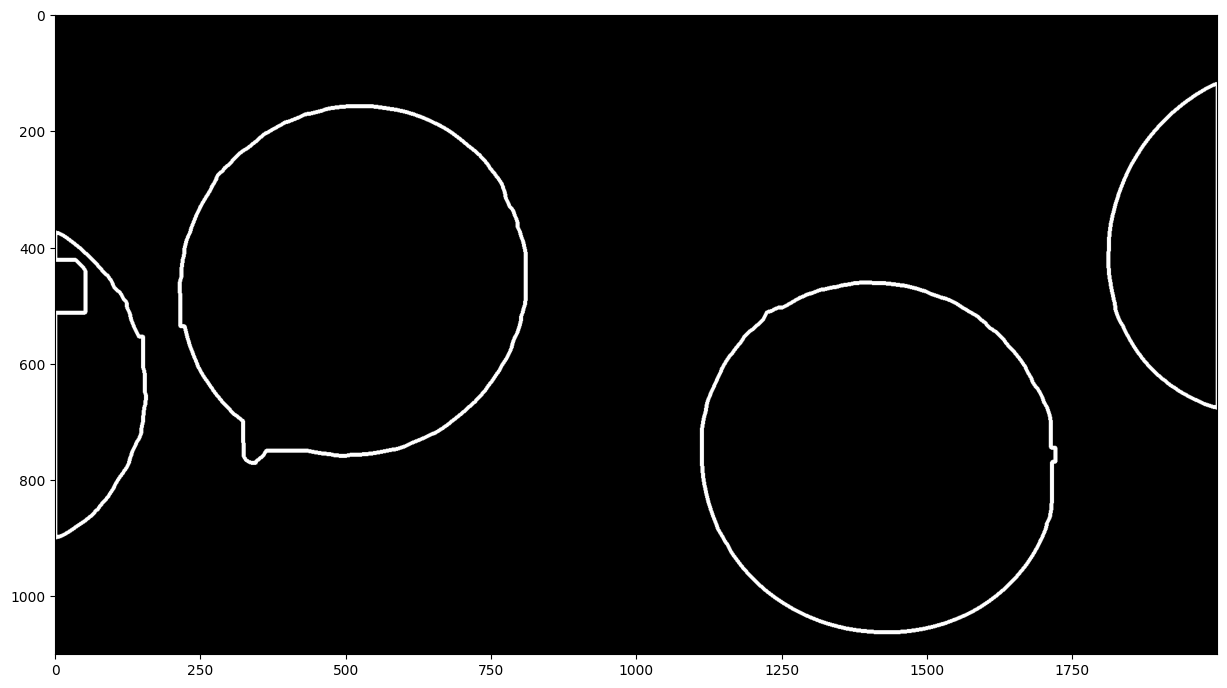

In [8]:
import cv2
import numpy as np

image = masks[10]
kernel1 = np.ones((15, 15), np.uint8)
kernel2 = np.ones((8, 8), np.uint8)
kernel3 = np.ones((30, 30), np.uint8)

image  = cv2.dilate(image, kernel=kernel2)

#median blur
# if image < 0.5: 0 else 255
image2 = np.where(image < 0.5, 0, 255)
image2 = image2.astype(np.uint8)

image = cv2.medianBlur(image2, 27)

image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel=kernel3, iterations=1)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel=kernel1, iterations=5)

# Threshold the image to create a binary mask
_, binary_mask = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)

# Find contours in the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Fill the contours with white color
filled_image = np.zeros_like(image)
#cv2.drawContours(filled_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
cv2.drawContours(filled_image, contours, -1, (255, 0, 0), thickness=5)

# Show the filled image
plt.figure(figsize=(15, 10))
plt.imshow(filled_image, cmap="gray")